In [1]:
# import libraries
import tensorflow as tf # for modell training
import matplotlib.pyplot as plt # to show graphical results
from matplotlib.ticker import MaxNLocator

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# own modules
import modules.config as config
from modules.ai_dataset import ai_dataset
from modules.export_trained_model import export_trained_model

In [4]:
# import training and testing data
test_data = ai_dataset(config.TEST_DATA, config.IMG_SIZE, True)
training_data = ai_dataset(config.TRAINING_DATA, config.IMG_SIZE, True)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 498.17it/s]

Errors: 0; Exceptions: 0


  0%|▎                                                                             | 47/12400 [00:00<00:26, 459.13it/s]

Errors: 0; Exceptions: 0
200 Images ready


  0%|▎                                                                             | 44/12400 [00:00<00:28, 434.07it/s]

Errors: 24; Exceptions: 0


100%|███████████████████████████████████████████████████████████████████████████| 12400/12400 [00:27<00:00, 451.60it/s]


Errors: 30; Exceptions: 0
24746 Images ready


In [5]:
training_data.get_status()

Image Data: (24746, 60, 60, 3)
Label Data: (24746,)
Class labels: dict_items([('Cat', 0), ('Dog', 1)])


In [6]:
test_data.get_status()

Image Data: (200, 60, 60, 3)
Label Data: (200,)
Class labels: dict_items([('Cat', 0), ('Dog', 1)])


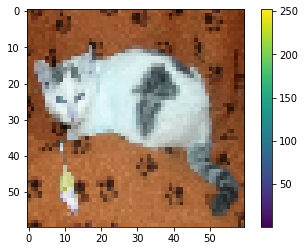

In [7]:
# show an image from the training data
plt.figure()
plt.imshow(training_data.get_image(0))
plt.colorbar()
plt.grid(False)
plt.show()

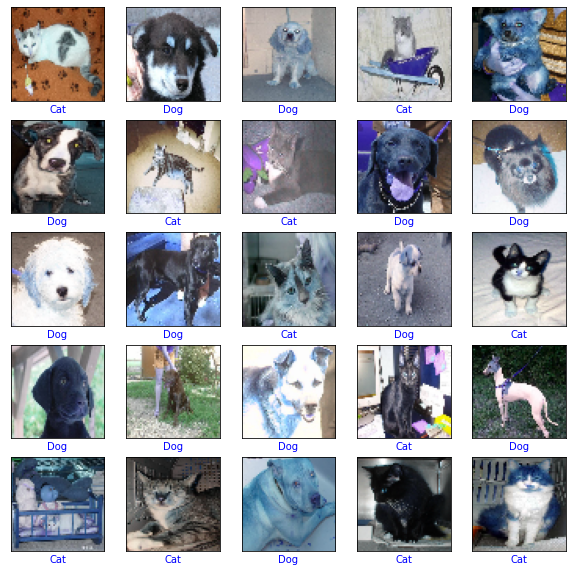

In [8]:
# verify preperation
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_data.get_image(i))
    plt.xlabel(training_data.get_label(i), color="blue")
plt.show()

In [12]:
# validate what hardware tf.keras is using for computing
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [14]:
# Create the convolutional base
model = tf.keras.models.Sequential(name="tf_model")
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(config.IMG_SIZE, config.IMG_SIZE, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

# Add Dense layers on top
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(training_data.get_labels_count()))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Run: 1
774/774 [==============================] - 48s 62ms/step - loss: 2.4543 - accuracy: 0.5828 - val_loss: 0.5968 - val_accuracy: 0.6950
7/7 - 0s - loss: 0.5968 - accuracy: 0.6950
INFO:tensorflow:Assets written to: C:\Users\MARCOW~1\AppData\Local\Temp\tmpaqqiipw0\assets
Run: 2
774/774 [==============================] - 48s 62ms/step - loss: 0.5768 - accuracy: 0.6927 - val_loss: 0.5352 - val_accuracy: 0.7750
7/7 - 0s - loss: 0.5352 - accuracy: 0.7750
INFO:tensorflow:Assets written to: C:\Users\MARCOW~1\AppData\Local\Temp\tmpm66r6ps7\assets
Run: 3
774/774 [==============================] - 48s 62ms/step - loss: 0.5061 - accuracy: 0.7558 - val_loss: 0.4868 - val_accuracy: 0.8050
7/7 - 0s - loss: 0.4868 - accuracy: 0.8050
INFO:tensorflow:Assets written to: C:\Users\MARCOW~1\AppData\Local\Temp\tmpccbihcsf\assets
Run: 4
774/774 [==============================] - 49s 64ms/step - loss: 0.4577 - accuracy: 0.7859 - val_loss: 0.4767 - val_accuracy: 0.7850
7/7 - 0s - loss: 0.4767 - accuracy: 0.

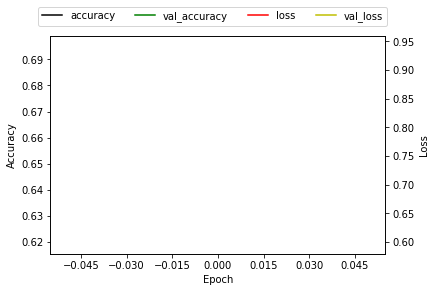

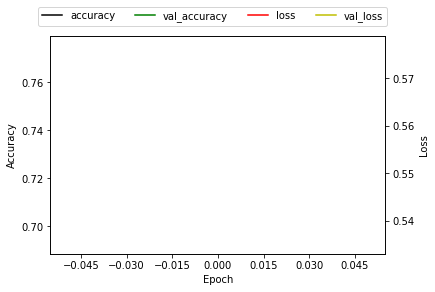

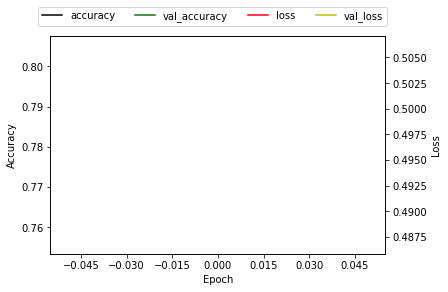

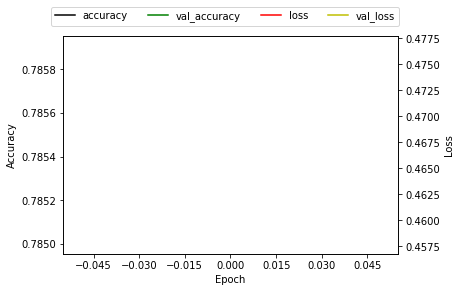

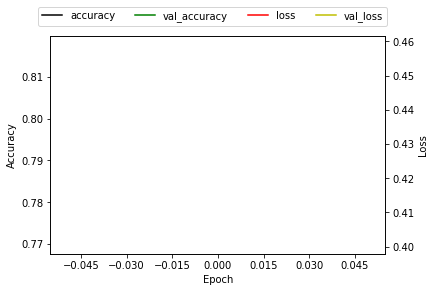

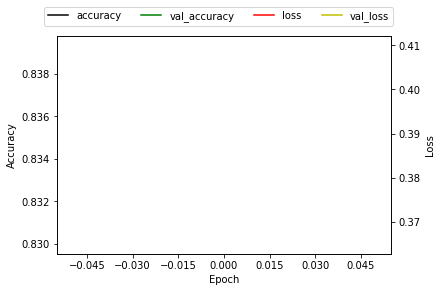

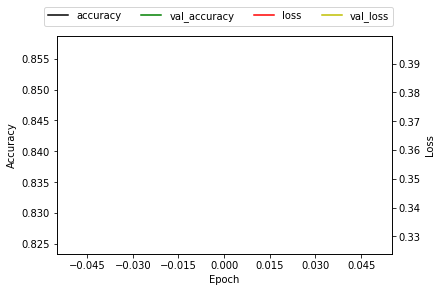

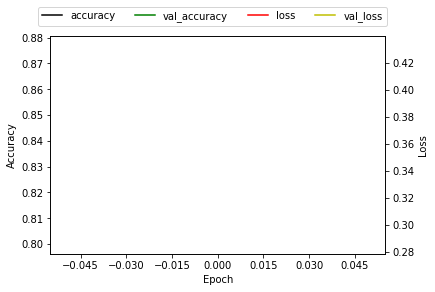

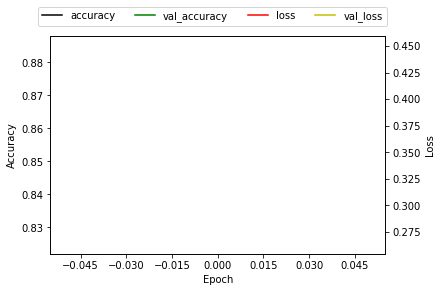

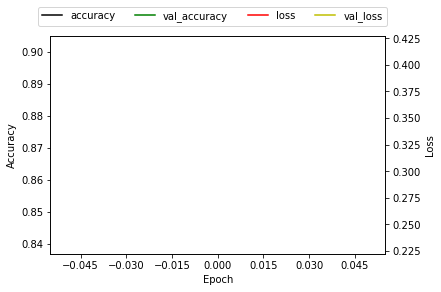

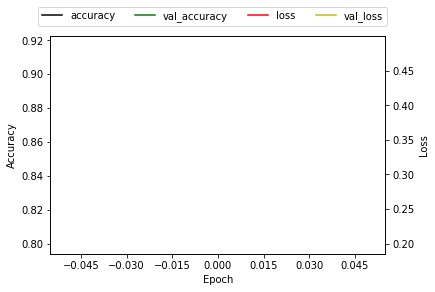

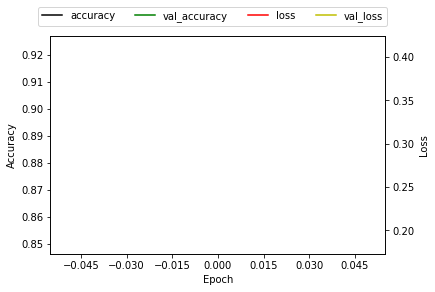

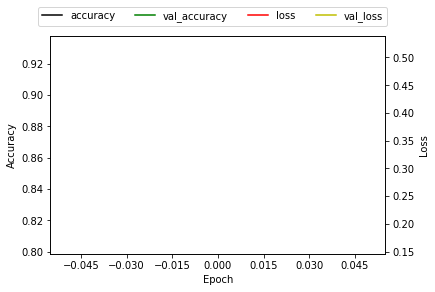

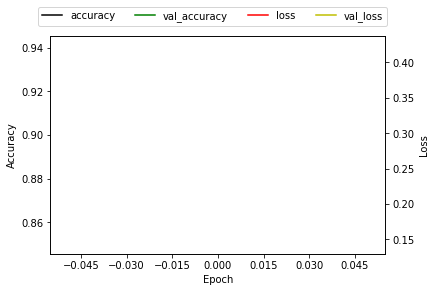

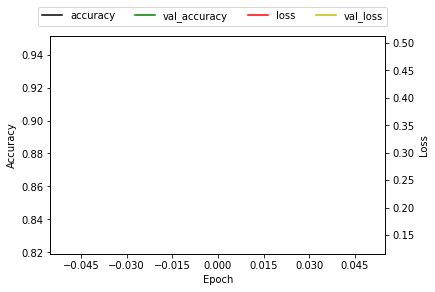

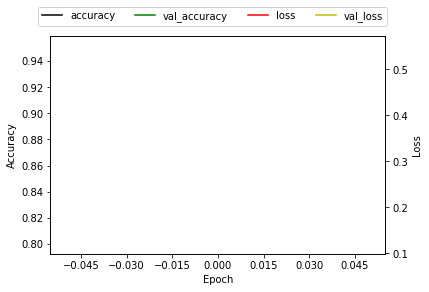

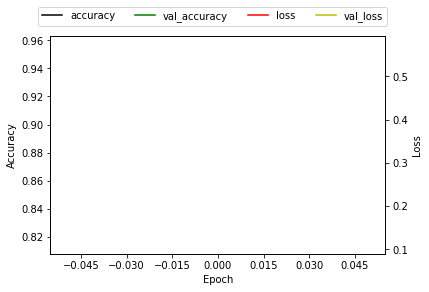

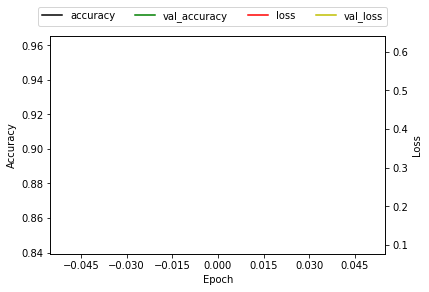

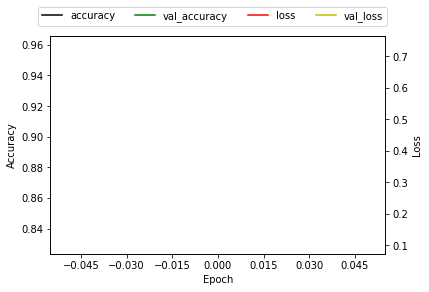

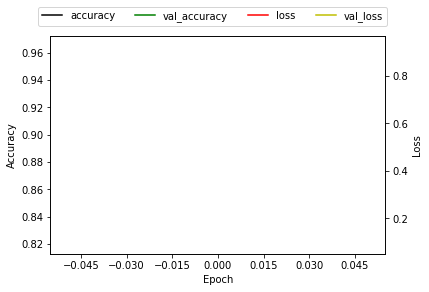

In [15]:
# Create multiple runs
histories = []
test_accs = []
runs = []
run_counter = 0
for i in range(1,config.TRAINING_EPOCHS+1):
    print("Run: " + str(i))
    run_counter+=1

    # train the model with variating epoch-count
    history = model.fit(training_data.get_tf_images(), training_data.get_tf_labels(), epochs=1, 
                validation_data=(test_data.get_tf_images(), test_data.get_tf_labels()))

    # Plot learning curve
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    ax1.plot(history.history["accuracy"], label = "accuracy", color = "k")
    ax1.plot(history.history["val_accuracy"], label = "val_accuracy", color = "g")
    ax2.plot(history.history["loss"], label = "loss", color = "r")
    ax2.plot(history.history["val_loss"], label = "val_loss", color = "y")
    ax1.set_xlabel("Epoch")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Loss")
    fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1., 0., 0.), ncol=4)

    # evaluate model
    test_loss, test_acc = model.evaluate(test_data.get_tf_images(), test_data.get_tf_labels(), verbose=2)

    export_trained_model(model, i, test_loss, test_acc, history, fig, training_data, config.MODEL_PATH)

    histories.append(history.history["accuracy"][-1])
    test_accs.append(test_acc)
    runs.append(run_counter)

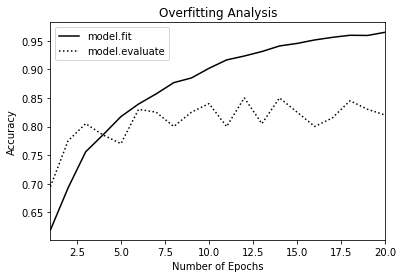

In [16]:
plt.plot(runs, histories, "k", linestyle = "solid", label = "model.fit")
plt.plot(runs, test_accs, "k", linestyle = "dotted", label = "model.evaluate")
plt.title("Overfitting Analysis")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()
plt.xlim([1, run_counter])
plt.savefig(config.MODEL_PATH+"/overfitting_analysis.png", dpi=100, transparent=False, facecolor="w")